Mount drive to extract the data zip

In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import zipfile
import os

# Unzip the uploaded zip file
zip_path = "/content/drive/MyDrive/deep learning/tumor otak.v8-augmentation-yolov7.multiclass.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

In [20]:
!ls dataset

README.dataset.txt  README.roboflow.txt  test  train  valid


In [21]:
import pandas as pd

def load_dataframe(subset):
    folder = f'dataset/{subset}/'
    df = pd.read_csv(folder + '_classes.csv')  # Assumes format: 'filename,label'
    # The label column is named 'class', not 'label' in the CSV file
    df = df.rename(columns={'class': 'label'}) #Rename the 'class' column to 'label'
    df['path'] = folder + df['filename']
    return df

df_train = load_dataframe('train')
df_val = load_dataframe('valid')
df_test = load_dataframe('test')

print(df_train.head())

                                           filename  glioma  meningioma  \
0  1392_jpg.rf.1f403fa7e5353558a62f86bc2373893a.jpg       0           0   
1   158_jpg.rf.edc2ad7465b6a17d73d7a5272cdaa4cd.jpg       0           1   
2  1360_jpg.rf.35962fabcb5e50f14035c1f6b3992e7a.jpg       0           0   
3  1439_jpg.rf.e1c04227c877bb4287c7932150afee5f.jpg       0           0   
4  1479_jpg.rf.196eecc896ea0c7c86d47fca882d8178.jpg       0           0   

   pituitary                                               path  
0          1  dataset/train/1392_jpg.rf.1f403fa7e5353558a62f...  
1          0  dataset/train/158_jpg.rf.edc2ad7465b6a17d73d7a...  
2          1  dataset/train/1360_jpg.rf.35962fabcb5e50f14035...  
3          1  dataset/train/1439_jpg.rf.e1c04227c877bb4287c7...  
4          1  dataset/train/1479_jpg.rf.196eecc896ea0c7c86d4...  


In [25]:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 128

def load_dataframe(subset):
    folder = f'dataset/{subset}/'
    df = pd.read_csv(folder + '_classes.csv')

    # Confirm columns exist before converting
    expected_columns = ['glioma', 'meningioma', 'pituitary']
    if not all(col in df.columns for col in expected_columns):
        raise ValueError(f"Expected columns {expected_columns} not found in CSV.")

    # Convert one-hot encoded labels to class name (e.g., "glioma")
    df['label'] = df[expected_columns].idxmax(axis=1)

    # Add full path to image
    df['path'] = folder + df['filename']

    return df



In [26]:
df_train = load_dataframe('train')
df_val = load_dataframe('valid')
df_test = load_dataframe('test')


In [27]:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 128

def load_images(df):
    images = []
    for path in df['path']:
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        images.append(img)
    return np.array(images)

# Encode labels
le = LabelEncoder()
df_train['label_encoded'] = le.fit_transform(df_train['label'])
df_val['label_encoded'] = le.transform(df_val['label'])
df_test['label_encoded'] = le.transform(df_test['label'])

X_train = load_images(df_train)
X_val = load_images(df_val)
X_test = load_images(df_test)

y_train = to_categorical(df_train['label_encoded'])
y_val = to_categorical(df_val['label_encoded'])
y_test = to_categorical(df_test['label_encoded'])


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.05),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'] )
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 899,171 (3.43 MB)

 Trainable params: 899,171 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 518s 3s/step - accuracy: 0.5717 - loss: 0.9106 - val_accuracy: 0.7337 - val_loss: 0.6410
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - accuracy: 0.6343 - loss: 0.7899 - val_accuracy: 0.7614 - val_loss: 0.5641
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - accuracy: 0.6725 - loss: 0.7358 - val_accuracy: 0.7876 - val_loss: 0.4892
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - accuracy: 0.6987 - loss: 0.6897 - val_accuracy: 0.8105 - val_loss: 0.4317
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 562s 3s/step - accuracy: 0.7328 - loss: 0.6257 - val_accuracy: 0.8072 - val_loss: 0.4271
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.7600 - loss: 0.5715 - val_accuracy: 0.8464 - val_loss: 0.3623
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - accuracy: 0.7810 - loss: 0.5364 - val_accuracy: 0.8007 - val_loss: 0.3955
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 555s 3s/step - accuracy: 0.7930 - loss: 0.4941 - val_accu

In [37]:
def predict_one(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    return le.inverse_transform([np.argmax(prediction)])

# Example:
predict_one(df_test['path'].iloc[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


array(['pituitary'], dtype=object)

In [38]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 560ms/step


In [39]:
from sklearn.metrics import classification_report

class_names = le.classes_
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

      glioma       0.95      0.90      0.93       159
  meningioma       0.78      0.90      0.84        62
   pituitary       0.97      0.95      0.96        87

    accuracy                           0.92       308
   macro avg       0.90      0.92      0.91       308
weighted avg       0.92      0.92      0.92       308



In [40]:
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize the labels (for multiclass AP computation)
y_true_bin = label_binarize(y_true, classes=[0,1,2])

# mAP = mean of average precision scores across all classes
aps = []
for i in range(3):
    ap = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    aps.append(ap)
    print(f"Class {class_names[i]} AP: {ap:.4f}")

mean_ap = np.mean(aps)
print(f"\nMean Average Precision (mAP): {mean_ap:.4f}")


Class glioma AP: 0.9742
Class meningioma AP: 0.8152
Class pituitary AP: 0.9928

Mean Average Precision (mAP): 0.9274


In [41]:
model.save('brain_tumor_cnn.h5')

In [42]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,697,515 (10.29 MB)

 Trainable params: 899,171 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,798,344 (6.86 MB)

In [ ]:
model.save('/content/drive/MyDrive/deep learning/yolov12m.h5')

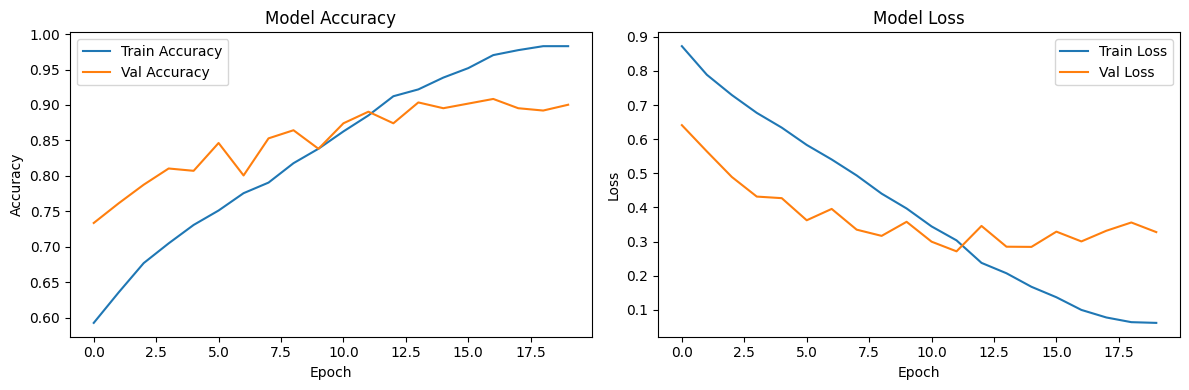

In [49]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 554ms/step


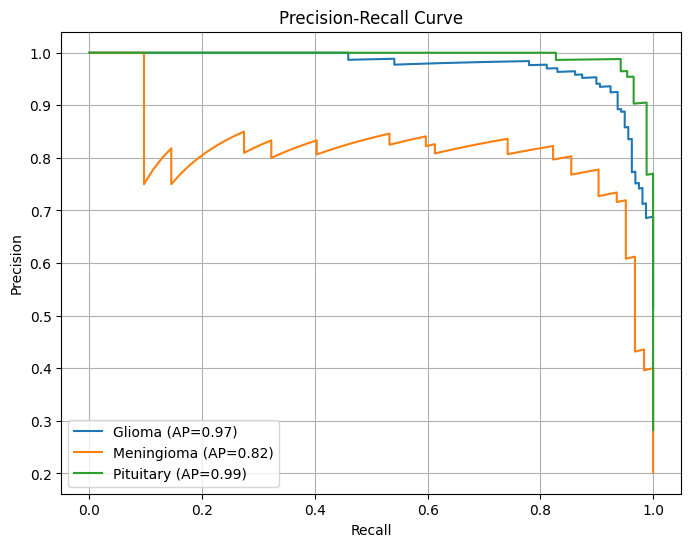

In [50]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Replace with your actual class names
class_names = ['Glioma', 'Meningioma', 'Pituitary']

# Convert y_test to 1-hot if it's not already
y_true = np.argmax(y_test, axis=1)
y_test_bin = label_binarize(y_true, classes=[0, 1, 2])  # adjust if more classes
y_score = model.predict(X_test)

# Plot PR curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP={ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


Gradio Interface Building

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt # Ensure matplotlib is imported if not already

# Load your model and label encoder (make sure these paths are correct)
# Ensure you have run the cell that saves the model ('brain_tumor_cnn.h5')
model = load_model('brain_tumor_cnn.h5')

# Ensure you have fitted the LabelEncoder before running this cell
# The 'le' object should be available from the previous cells where it was fitted on training labels
# If not, you might need to refit it or load it if saved
try:
    le.classes_
except NameError:
    # If le is not defined (e.g., running this cell independently),
    # you need to initialize and fit it or load it.
    # Assuming you ran the cells above, le should be available.
    # As a fallback/check:
    print("LabelEncoder 'le' not found. Ensure previous cells were run.")
    # You might need to reload dataframes and fit le again if running this cell isolated.
    # le = LabelEncoder()
    # le.fit(['glioma', 'meningioma', 'pituitary']) # Or fit on df_train['label']

# As a failsafe, explicitly set classes based on known data
le.classes_ = np.array(['glioma', 'meningioma', 'pituitary'])


IMG_SIZE = 128  # Should match your model's expected input size

def predict_tumor(image):
    """Make prediction on a single image"""
    # Gradio's gr.Image provides input image as numpy array in RGB format
    # Preprocess the image for the model (model expects normalized RGB)
    # Ensure input is RGB before resizing/normalizing if it came from cv2.imread somewhere else,
    # but Gradio's gr.Image input *should* be RGB already.
    # Let's assume 'image' input from gr.Image is RGB.

    img_processed = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    img_processed = img_processed / 255.0  # Normalize
    img_processed = np.expand_dims(img_processed, axis=0)

    # Make prediction
    prediction = model.predict(img_processed)
    class_idx = np.argmax(prediction)
    class_name = le.inverse_transform([class_idx])[0]
    confidence = prediction[0][class_idx]

    # Create visualization for output display
    # Resize the original input image (which is RGB from Gradio) for display
    overlay = cv2.resize(image, (512, 512)) # Resize original RGB image (uint8)
    # Convert the RGB image to BGR for cv2.putText
    overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)

    # Add text to the BGR image
    cv2.putText(overlay_bgr, f"{class_name} ({confidence:.2f})",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2) # Text color is (B, G, R)

    # Convert the BGR image back to RGB for Gradio display
    overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

    # Prepare probabilities dictionary
    prob_dict = {le.classes_[i]: float(prediction[0][i]) for i in range(len(le.classes_))}

    return overlay_rgb, prob_dict

# Create the Gradio interface
with gr.Blocks(title="Brain Tumor Detection") as demo:
    gr.Markdown("# Brain Tumor Detection with CNN")
    gr.Markdown("Upload a brain scan image to detect tumors (glioma, meningioma, or pituitary)")

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(label="Upload Brain Scan")
            submit_btn = gr.Button("Detect Tumor")

        with gr.Column():
            image_output = gr.Image(label="Detection Result")
            label_output = gr.Label(label="Prediction Probabilities")

   

if __name__ == "__main__":
    demo.launch(server_name="0.0.0.0")

Caching examples at: '/content/.gradio/cached_examples/455'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fb6918fc239427b552.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
